In [1]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
comex_df=pd.read_csv('/home/andre301267/git/BD/temp/imp_fert_ncm_quanti.csv').sort_values(by=['CO_ANO','CO_MES'])

In [2]:
comex_df.insert(0,'date',pd.to_datetime(comex_df.CO_ANO.astype(str)+'/'+comex_df.CO_MES.astype(str)+'/1'))

In [3]:
data_ini=comex_df.date.min()
data_ini

Timestamp('1997-01-01 00:00:00')

In [4]:
data_fim=comex_df.date.max()
data_fim

Timestamp('2024-08-01 00:00:00')

# 1a Fase: Seleciona a planilha de interesse

In [5]:
comex_df.nick.unique()

array(['MOP', 'MOP<60', 'NK', 'NPK', 'Nit.Sódio Potássico 15 15',
       'Outros N', 'Outros nitratos de sódio', 'SAM', 'SOP<52', 'MAP',
       'NAM', 'Nit.Sódio natural<16,3', 'Outros Nit.Sódio potássico',
       'Outros potássicos', 'Superfosfatos<22', 'UREIA',
       'DAP arsênio> 6 mg/kg', 'NCa', 'Outros SOP', 'PK',
       'Superfosfato>45', 'Ureia, mesmo aquosa',
       'Outros Nit.Sódio, naturais', 'NP', 'Nitratos e fosfatos',
       'Superfosfatos>35', 'Outros superfosfatos'], dtype=object)

In [6]:
nick=['MOP']
UF=['BA']
CO_PAIS=[]
CO_URF=[]

l=['nick','UF','CO_PAIS','CO_URF']
d={'nick':nick,'UF':UF,'CO_PAIS':CO_PAIS,'CO_URF':CO_URF}
for x in l:
    if len(d[x])>0:
        comex_df=comex_df[comex_df[x].isin(d[x])]
    else:
        comex_df.drop(columns=x,inplace=True)

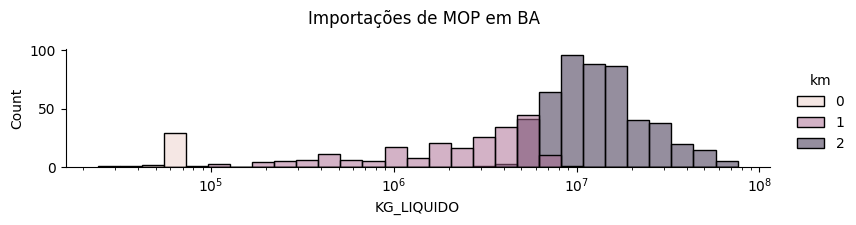

In [7]:
sns.displot(data=comex_df,x='KG_LIQUIDO',hue='km', log_scale=True,height=2,aspect=4)\
.fig.suptitle(f"Importações de {nick[0]} em {UF[0]}",y=1.1)
plt.show()

In [8]:
km=2

In [9]:
comex_df=comex_df[comex_df.km==km]
comex_df.drop(columns='km',inplace=True)

# 2a Fase: Sparse Matrix - train

In [10]:
col_ord=['CO_ANO','CO_MES']

In [11]:
col_cat=[x for x in l if x in comex_df.columns.tolist()]

In [12]:
col_quanti=['KG_LIQUIDO','VL_FOB','VL_FRETE']

In [13]:
comex_df=comex_df[col_ord+col_cat+col_quanti].sort_values(by=col_ord)

In [14]:
comex_df.shape

(498, 7)

In [15]:
comex_df[col_ord+col_cat]=comex_df[col_ord+col_cat].astype('category')

In [16]:
comex_df_g=comex_df.groupby(by=col_ord+col_cat,observed=False)[col_quanti].sum().reset_index()

In [17]:
comex_df_g.insert(0,'date',pd.to_datetime(comex_df_g.CO_ANO.astype(str)+'/'+comex_df_g.CO_MES.astype(str)+'/1'))

In [18]:
comex_df_g=comex_df_g[(comex_df_g.date>=data_ini)&(comex_df_g.date<=data_fim)].sort_values('date')

In [19]:
train=comex_df_g

# 3a Fase: X_pred

In [20]:
ini_pred=comex_df_g.date.max()+DateOffset(months=1)

In [21]:
fim_pred=ini_pred+DateOffset(months=11)

In [22]:
pred_date_range=pd.date_range(ini_pred,fim_pred,freq='MS')

In [23]:
pred_cal=pd.DataFrame({'date':pred_date_range})
pred_cal=pred_cal.assign(CO_ANO=pred_cal.date.dt.year)
pred_cal=pred_cal.assign(CO_MES=pred_cal.date.dt.month)
pred_cal=pred_cal.assign(key=0)
pred_cal

,date,CO_ANO,CO_MES,key
0,2024-09-01,2024,9,0
1,2024-10-01,2024,10,0
2,2024-11-01,2024,11,0
3,2024-12-01,2024,12,0
4,2025-01-01,2025,1,0
5,2025-02-01,2025,2,0
6,2025-03-01,2025,3,0
7,2025-04-01,2025,4,0
8,2025-05-01,2025,5,0
9,2025-06-01,2025,6,0


In [24]:
pred_cat=comex_df_g[col_cat].drop_duplicates().assign(key=0)

In [25]:
pred_cat

,nick,UF,key
0,MOP,BA,0


In [26]:
X_pred=pred_cal.merge(pred_cat).drop(columns='key')

In [27]:
X_pred

,date,CO_ANO,CO_MES,nick,UF
0,2024-09-01,2024,9,MOP,BA
1,2024-10-01,2024,10,MOP,BA
2,2024-11-01,2024,11,MOP,BA
3,2024-12-01,2024,12,MOP,BA
4,2025-01-01,2025,1,MOP,BA
5,2025-02-01,2025,2,MOP,BA
6,2025-03-01,2025,3,MOP,BA
7,2025-04-01,2025,4,MOP,BA
8,2025-05-01,2025,5,MOP,BA
9,2025-06-01,2025,6,MOP,BA


# 3a Fase: Dummies

In [28]:
comex_df_o=pd.concat([train,X_pred])

In [29]:
comex_df_o.CO_MES=comex_df_o.CO_MES.astype('category')

In [30]:
comex_df_o.drop(columns='CO_ANO',inplace=True)

In [31]:
comex_df_o

,date,CO_MES,nick,UF,KG_LIQUIDO,VL_FOB,VL_FRETE
0,1997-01-01,1,MOP,BA,0.0,0.0,0.0
1,1997-02-01,2,MOP,BA,0.0,0.0,0.0
2,1997-03-01,3,MOP,BA,0.0,0.0,0.0
3,1997-04-01,4,MOP,BA,0.0,0.0,0.0
4,1997-05-01,5,MOP,BA,0.0,0.0,0.0
...,...,...,...,...,...,...,...
7,2025-04-01,4,MOP,BA,NaN,NaN,NaN
8,2025-05-01,5,MOP,BA,NaN,NaN,NaN
9,2025-06-01,6,MOP,BA,NaN,NaN,NaN
10,2025-07-01,7,MOP,BA,NaN,NaN,NaN


In [32]:
comex_df_o.date=comex_df_o.date.astype(int)

In [33]:
comex_df_dumm=pd.get_dummies(comex_df_o, prefix_sep='~')

In [34]:
comex_df_dumm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 344 entries, 0 to 11
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        344 non-null    int64  
 1   KG_LIQUIDO  332 non-null    float64
 2   VL_FOB      332 non-null    float64
 3   VL_FRETE    332 non-null    float64
 4   CO_MES~1    344 non-null    bool   
 5   CO_MES~2    344 non-null    bool   
 6   CO_MES~3    344 non-null    bool   
 7   CO_MES~4    344 non-null    bool   
 8   CO_MES~5    344 non-null    bool   
 9   CO_MES~6    344 non-null    bool   
 10  CO_MES~7    344 non-null    bool   
 11  CO_MES~8    344 non-null    bool   
 12  CO_MES~9    344 non-null    bool   
 13  CO_MES~10   344 non-null    bool   
 14  CO_MES~11   344 non-null    bool   
 15  CO_MES~12   344 non-null    bool   
 16  nick~MOP    344 non-null    bool   
 17  UF~BA       344 non-null    bool   
dtypes: bool(14), float64(3), int64(1)
memory usage: 18.1 KB


# 4a fase: Classificação

In [35]:
comex_df_dumm=comex_df_dumm.assign(oc=1)

In [36]:
comex_df_dumm.loc[comex_df_dumm.KG_LIQUIDO==0,'oc']=0

In [37]:
comex_df_dumm.loc[comex_df_dumm.KG_LIQUIDO.isna(),'oc']=np.nan

In [38]:
train=comex_df_dumm[~comex_df_dumm.oc.isna()]

In [39]:
pred=comex_df_dumm[comex_df_dumm.oc.isna()]

In [40]:
X_train=train[['date']+train.select_dtypes('bool').columns.tolist()]

In [41]:
y_train=train['oc']

In [42]:
X_pred=pred[['date']+pred.select_dtypes('bool').columns.tolist()]

In [43]:
from sklearn.ensemble import RandomForestClassifier as RFC
RFC=RFC()
RFC.fit(X_train,y_train)
pred=pd.concat([X_pred,pd.DataFrame({'oc':RFC.predict(X_pred)})],axis=1)

In [44]:
pred

,date,CO_MES~1,CO_MES~2,CO_MES~3,CO_MES~4,CO_MES~5,CO_MES~6,CO_MES~7,CO_MES~8,CO_MES~9,CO_MES~10,CO_MES~11,CO_MES~12,nick~MOP,UF~BA,oc
0,1725148800000000000,False,False,False,False,False,False,False,False,True,False,False,False,True,True,1.0
1,1727740800000000000,False,False,False,False,False,False,False,False,False,True,False,False,True,True,1.0
2,1730419200000000000,False,False,False,False,False,False,False,False,False,False,True,False,True,True,1.0
3,1733011200000000000,False,False,False,False,False,False,False,False,False,False,False,True,True,True,1.0
4,1735689600000000000,True,False,False,False,False,False,False,False,False,False,False,False,True,True,1.0
5,1738368000000000000,False,True,False,False,False,False,False,False,False,False,False,False,True,True,1.0
6,1740787200000000000,False,False,True,False,False,False,False,False,False,False,False,False,True,True,1.0
7,1743465600000000000,False,False,False,True,False,False,False,False,False,False,False,False,True,True,1.0
8,1746057600000000000,False,False,False,False,True,False,False,False,False,False,False,False,True,True,1.0
9,1748736000000000000,False,False,False,False,False,True,False,False,False,False,False,False,True,True,1.0


# 5a fase: Regression

In [45]:
train=train[train.oc==1]

In [46]:
pred=pred[pred.oc==1]

In [47]:
X_train=train[['date']+train.select_dtypes('bool').columns.tolist()]

In [48]:
X_train.columns

Index(['date', 'CO_MES~1', 'CO_MES~2', 'CO_MES~3', 'CO_MES~4', 'CO_MES~5',
       'CO_MES~6', 'CO_MES~7', 'CO_MES~8', 'CO_MES~9', 'CO_MES~10',
       'CO_MES~11', 'CO_MES~12', 'nick~MOP', 'UF~BA'],
      dtype='object')

In [49]:
y_train=train[col_quanti]

In [50]:
X_pred=pred[['date']+pred.select_dtypes('bool').columns.tolist()]

In [51]:
from sklearn.ensemble import RandomForestRegressor as RFR
RFR=RFR(max_features=1, max_depth=50)
RFR.fit(X_train,y_train)
pred=pd.concat([X_pred,pd.DataFrame(RFR.predict(X_pred),columns=col_quanti)],axis=1)

# 6a fase: montagem final

In [52]:
final=pd.concat([train,pred])

In [53]:
final

,date,KG_LIQUIDO,VL_FOB,VL_FRETE,CO_MES~1,CO_MES~2,CO_MES~3,CO_MES~4,CO_MES~5,CO_MES~6,CO_MES~7,CO_MES~8,CO_MES~9,CO_MES~10,CO_MES~11,CO_MES~12,nick~MOP,UF~BA,oc
7,870393600000000000,1.082378e+07,2778760.00,259776.00,False,False,False,False,False,False,False,True,False,False,False,False,True,True,1.0
9,875664000000000000,1.724462e+07,4537242.00,411964.00,False,False,False,False,False,False,False,False,False,True,False,False,True,True,1.0
10,878342400000000000,1.074219e+07,2905814.00,252000.00,False,False,False,False,False,False,False,False,False,False,True,False,True,True,1.0
11,880934400000000000,8.708794e+06,2407828.00,208800.00,False,False,False,False,False,False,False,False,False,False,False,True,True,True,1.0
15,891388800000000000,8.049864e+06,2160464.00,192000.00,False,False,False,True,False,False,False,False,False,False,False,False,True,True,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,1743465600000000000,6.545202e+07,23864214.18,3177508.96,False,False,False,True,False,False,False,False,False,False,False,False,True,True,NaN
8,1746057600000000000,1.122111e+08,38769822.46,5239828.15,False,False,False,False,True,False,False,False,False,False,False,False,True,True,NaN
9,1748736000000000000,1.112201e+08,32366317.77,4748347.94,False,False,False,False,False,True,False,False,False,False,False,False,True,True,NaN
10,1751328000000000000,7.213084e+07,29083241.68,3430349.32,False,False,False,False,False,False,True,False,False,False,False,False,True,True,NaN


In [54]:
d=final[['date']].astype('datetime64[ns]')

In [55]:
m=pd.from_dummies(final.loc[:,final.columns.str.contains('CO_MES')],sep='~')

In [56]:
n=pd.from_dummies(final.loc[:,final.columns.str.contains('nick')],sep='~')

In [57]:
u=pd.from_dummies(final.loc[:,final.columns.str.contains('UF')],sep='~')

In [58]:
final=pd.concat([d,m,n,u,final[col_quanti]],axis=1)
final

,date,CO_MES,nick,UF,KG_LIQUIDO,VL_FOB,VL_FRETE
7,1997-08-01,8,MOP,BA,1.082378e+07,2778760.00,259776.00
9,1997-10-01,10,MOP,BA,1.724462e+07,4537242.00,411964.00
10,1997-11-01,11,MOP,BA,1.074219e+07,2905814.00,252000.00
11,1997-12-01,12,MOP,BA,8.708794e+06,2407828.00,208800.00
15,1998-04-01,4,MOP,BA,8.049864e+06,2160464.00,192000.00
...,...,...,...,...,...,...,...
7,2025-04-01,4,MOP,BA,6.545202e+07,23864214.18,3177508.96
8,2025-05-01,5,MOP,BA,1.122111e+08,38769822.46,5239828.15
9,2025-06-01,6,MOP,BA,1.112201e+08,32366317.77,4748347.94
10,2025-07-01,7,MOP,BA,7.213084e+07,29083241.68,3430349.32


In [59]:
final=final.assign(tipo='pred')

In [60]:
final.loc[final.date<=data_fim,'tipo']='train'

In [61]:
final

,date,CO_MES,nick,UF,KG_LIQUIDO,VL_FOB,VL_FRETE,tipo
7,1997-08-01,8,MOP,BA,1.082378e+07,2778760.00,259776.00,train
9,1997-10-01,10,MOP,BA,1.724462e+07,4537242.00,411964.00,train
10,1997-11-01,11,MOP,BA,1.074219e+07,2905814.00,252000.00,train
11,1997-12-01,12,MOP,BA,8.708794e+06,2407828.00,208800.00,train
15,1998-04-01,4,MOP,BA,8.049864e+06,2160464.00,192000.00,train
...,...,...,...,...,...,...,...,...
7,2025-04-01,4,MOP,BA,6.545202e+07,23864214.18,3177508.96,test
8,2025-05-01,5,MOP,BA,1.122111e+08,38769822.46,5239828.15,test
9,2025-06-01,6,MOP,BA,1.112201e+08,32366317.77,4748347.94,test
10,2025-07-01,7,MOP,BA,7.213084e+07,29083241.68,3430349.32,test


In [62]:
dict_mes={'1':'01','2':'02','3':'03','4':'04','5':'05','6':'06','7':'07','8':'08','9':'09'}

In [63]:
final['CO_MES'] = final['CO_MES'].replace(dict_mes)

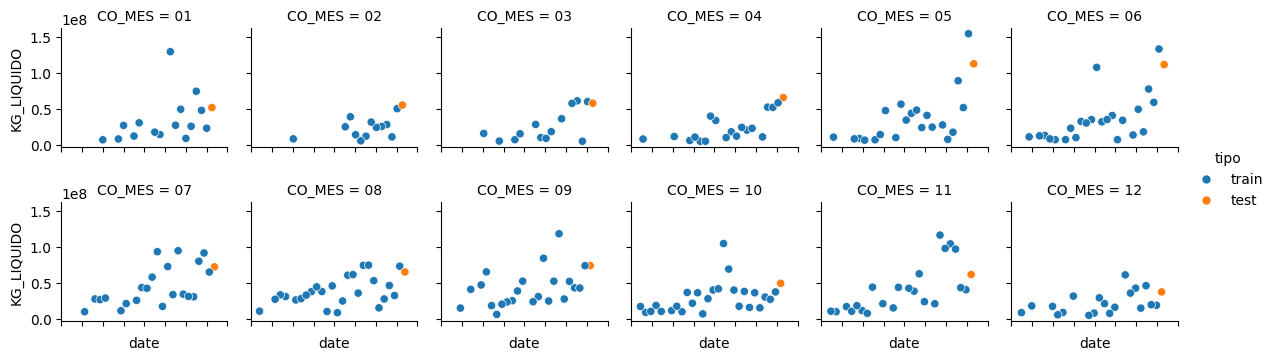

In [64]:
g=sns.relplot(data=final.sort_values('CO_MES'),x='date',y='KG_LIQUIDO',hue='tipo',col='CO_MES',col_wrap=6,height=2)
g=g.set_xticklabels(rotation=45)
plt.show()

In [65]:
final.tail(20)

,date,CO_MES,nick,UF,KG_LIQUIDO,VL_FOB,VL_FRETE,tipo
324,2024-01-01,01,MOP,BA,2.306643e+07,6461393.00,1126047.00,train
325,2024-02-01,02,MOP,BA,5.014752e+07,16318801.00,2556436.00,train
326,2024-03-01,03,MOP,BA,5.984267e+07,14919266.00,2578178.00,train
327,2024-04-01,04,MOP,BA,5.821750e+07,16883537.00,2992481.00,train
328,2024-05-01,05,MOP,BA,1.539414e+08,44040086.00,6898023.00,train
329,2024-06-01,06,MOP,BA,1.328179e+08,35560778.00,5659910.00,train
330,2024-07-01,07,MOP,BA,6.498920e+07,20942751.00,2927514.00,train
331,2024-08-01,08,MOP,BA,7.307432e+07,18784784.00,3138905.00,train
0,2024-09-01,09,MOP,BA,7.389049e+07,28376802.39,3080152.22,test
1,2024-10-01,10,MOP,BA,4.939115e+07,17859695.81,2475408.16,test
